In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import *
from src.files import *  
import glob
import scipy
import matplotlib as mpl 
%load_ext autoreload
%autoreload 2

# NOTE: The MAG annotations in the metadata might be wrong... 
ece_id = 'ece_26_1334'

In [2]:
dpann_phyla = ['Diapherotrites', 'Parvarchaeota', 'Aenigmarchaeota', 'Nanoarchaeota', 'Nanohaloarchaeota', 'Woesearchaeota', 'Pacearchaeota', 'Micrarchaeota', 'Altiarchaeota', 'Huberarchaeota', 'Undinarchaeota', 'Iainarchaeota']

levels = ['phylum', 'genus', 'class', 'order', 'species', 'domain', 'family']
level_funcs = dict(list(zip(levels, [get_phylum, get_genus, get_class, get_order, get_species, get_domain, get_family])))

In [3]:
# How many total spacers do we have?
genome_id_pattern = r'SR-VP_\d{2}_\d{2}_\d{4}_(ck|N)_(top|bottom|middle)([\.|_])(vamb|metabat2|maxbin2|concoct)([\.|_])(\d+)(_sub)*'
get_genome_id = lambda string : re.search(genome_id_pattern, string).group(0).replace('.', '_')

def fasta_count_sequences(path:str):
    cmd = f'cat {path} | grep -o ">" | wc -l'
    result = subprocess.run(cmd, shell=True, check=True, capture_output=True, text=True)
    return int(result.stdout)

n = sum([fasta_count_sequences(path) for path in glob.glob('../data/spacers/near_cas/*')])
print('Num. sequences in FASTA files:', n)

Num. sequences in FASTA files: 2043


In [4]:
# Time to take a look at the CRISPR spacers! Specifically, looking for hits to the DPANN Archaea within the CRISPR spacers. 
# Perhaps make a target database out of the DPANN Archaea.  

metadata_df = load_metadata()
for level, level_func in level_funcs.items():
    metadata_df[level] = metadata_df.taxonomy.apply(level_func)
metadata_df['dpann'] = metadata_df.phylum.isin(dpann_phyla)

dpann_genome_ids = metadata_df[metadata_df.dpann].index.str.replace('.', '_', regex=False)
dpann_genome_ids = np.unique(dpann_genome_ids)
print('Num. DPANN genomes:', len(dpann_genome_ids))

Num. DPANN genomes: 30


In [5]:
# Want to make a BLAST database of the DPANN genomes for a target database. 
def make_dpann_blast_database(database_path='../data/blast/databases/dpann', dpann_genome_ids=dpann_genome_ids):

    # Clear the file if it already exists. 
    subprocess.run(f'> {database_path}.fn', shell=True, check=True)

    for path in glob.glob('../data/genomes/*'):
        genome_id = os.path.basename(path).replace('.fn', '')
        if genome_id in dpann_genome_ids: # Concatenate all DPANN genomes into a single FASTA file. 
            subprocess.run(f'cat {path} >> {database_path}.fn', shell=True, check=True)

    # The parse_seqids option basically gets rid of the FASTA description. 
    subprocess.run(f'makeblastdb -in {database_path}.fn -out {database_path} -dbtype nucl -parse_seqids', shell=True, check=True)

# make_dpann_blast_database()
        

In [6]:
output_dir = '../data/blast/output'
query_extension = '.fa'
database_path = '../data/blast/databases/dpann'
for query_path in tqdm(glob.glob('../data/spacers/orphan/*'), desc='Searching BLAST target database for spacer hits...'):
    output_path = os.path.join(output_dir, os.path.basename(query_path).replace(query_extension, '.tsv')) 
    if not os.path.exists(output_path):
        subprocess.run(f'cctk spacerblast -o {output_path} -d {database_path} -s {query_path}', shell=True, check=True)

Searching BLAST target database for spacer hits...:   0%|          | 0/182 [00:00<?, ?it/s]ERROR running blast on ../data/blast/databases/dpann:
BLAST Database error: No alias or index file found for nucleotide database [../data/blast/databases/dpann] in search path [/home/prichter/Documents/rotations/banfield/notebooks::]. Please verify the spelling of the BLAST database and its molecule type.
Searching BLAST target database for spacer hits...: 100%|██████████| 182/182 [00:00<00:00, 276.04it/s]


In [7]:
scaffold_to_bin_map = load_scaffold_to_bin_map()

blast_df = list()
for path in glob.glob(os.path.join(output_dir, '*')):
    has_cas = not 'orphan' in path
    blast_df.append(pd.read_csv(path, sep=r'\s+').assign(query_path=path, has_cas=has_cas))
blast_df = pd.concat(blast_df)
blast_df.columns = blast_df.columns.str.lower()
# blast_df['query_genome_id'] = blast_df.spacer_id.str.replace(r'_\d+:\d+', '', regex=True).map(scaffold_to_bin_map)
blast_df['query_genome_id'] = blast_df.query_path.apply(get_genome_id)
blast_df['target_genome_id'] = blast_df.target_contig.map(scaffold_to_bin_map).apply(get_genome_id)
# Apparently any spacer hits with more than one mismatch are insignificant. 
blast_df = blast_df[blast_df.mismatches <= 1].copy()

# Found out that the CRISPR array SR-VP_05_06_2024_ck_bottom_scaffold_10379_2 is a false positive, seems like the direct repeats
# are part of a protein and were mis-identified. 
blast_df = blast_df[~blast_df.spacer_id.str.contains('SR-VP_05_06_2024_ck_bottom_scaffold_10379_2')].copy()


In [8]:
blast_df = blast_df[blast_df.percent_identity > 80].copy()
metadata_df = metadata_df[~metadata_df.index.duplicated()].copy()
metadata_df.index = metadata_df.index.str.replace('.', '_', regex=False)

for col in list(level_funcs.keys()) + ['dpann']:
    blast_df[f'target_{col}'] = blast_df.target_genome_id.map(metadata_df[col])
    blast_df[f'query_{col}'] = blast_df.query_genome_id.map(metadata_df[col])

In [9]:
# The BLAST query sequences are the predicted spacer, and the targets are things with matches. 
# There are some cases of a detected spacer being identified on the same scaffold, which I think means that the 
# BLAST target database just contains the sequence on which the spacer was predicted. 

scaffold_id_pattern = r'SR-VP_\d{2}_\d{2}_\d{4}_(ck|N)_(top|bottom|middle)_scaffold_\d+'
get_scaffold_id = lambda string : re.search(scaffold_id_pattern, string).group(0).replace('.', '_')
get_scaffold_id('SR-VP_05_06_2024_ck_bottom_scaffold_395')

blast_df['query_contig'] = blast_df.spacer_id.apply(get_scaffold_id)

print('Num. meaningless BLAST hits:', (blast_df.query_contig == blast_df.target_contig).sum()) # These are likely just hits to the spacer itself.
print('Num. hits with a Cas:', blast_df.has_cas.sum())
print('Num. hits to an orphan spacer:', (~blast_df.has_cas).sum())

# The BLAST query sequences are the predicted spacer, and the targets are things with matches. 
blast_df = blast_df[blast_df.target_contig != blast_df.query_contig].copy()
# print('Num. hits to other potential DPANN:', blast_df.query_dpann.sum())

# # Neither of the spacers of interest have associated Cas. 
blast_df = blast_df[blast_df.target_contig == 'SR-VP_05_06_2024_N_middle_scaffold_11254'].copy()
spacer_genome_ids = blast_df.query_genome_id.unique()

# 86 spacers in the SR-VP_05_06_2024_ck_bottom_maxbin2_42 array, one array in assembly. 
# (1) 73  and (2) 12 spacers in the SR-VP_05_06_2024_N_top_maxbin2_40 array, two arrays in assembly.

Num. meaningless BLAST hits: 128
Num. hits with a Cas: 70
Num. hits to an orphan spacer: 186


In [10]:
# ECE aligns to the following contigs:
# SR-VP_05_06_2024_N_bottom_scaffold_6272
# SR-VP_05_06_2024_ck_bottom_scaffold_14226
# SR-VP_05_06_2024_N_middle_scaffold_11254
# SR-VP_05_06_2024_N_top_scaffold_11797

# Only put in a bin in ck_bottom and N_middle, which explains why there are only CRISPR array hits in these samples. My target 
# database only contains sequences from non-unknown bins. 

ece_abundance = dict()
ece_abundance['SR-VP_05_06_2024_N_bottom_scaffold_6272'] = 128.92
ece_abundance['SR-VP_05_06_2024_ck_bottom_scaffold_14226'] = 607.23 
ece_abundance['SSR-VP_05_06_2024_N_middle_scaffold_11254'] =  218.23
ece_abundance['SR-VP_05_06_2024_N_top_scaffold_11797'] = 380.62

# Abundances in the environmental samples...
# Coverage units are already normalized, basically a measure of the average number of times each base is sequenced. 
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_15277'] = 1.98
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_16350'] = 4.2
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_14394'] = 2.07
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_19486'] = 3.31
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_25164'] = 3.32
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_32691'] = 1.89
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_26906'] = 6.82
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_81867'] = 2.96
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_100246'] = 1.05
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_131869'] = 4.42
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_140284'] = 2.73
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_209635'] = 4.68
ece_abundance['SR-VP_11_27_2022_S1_100cm_scaffold_2222'] = 9.49

get_metagenome_id = lambda id_ : re.search(r'(S[12]_\d+cm|N_middle|N_top|N_bottom|ck_bottom)', id_).group(0).lower()

def load_organism_info(path:str, ece_abundance:dict=ece_abundance):
    metagenome_id = os.path.basename(path).replace('_organism_info.tsv', '')
    cols = ['id','name','taxonomy','bin length','GC%','coverage', 'curation status','completion status']
    df = pd.read_csv(path, sep='\t', usecols=cols)
    df.columns = [col.lower().replace(' ', '_') if (col != 'GC%') else 'gc_percent' for col in df.columns]
    df['metagenome_id'] = metagenome_id
    df = df[df.coverage > 0].copy()
    df = df.drop(columns=['id']).set_index('name')

    # Add the ECE abundance prior to normalization. 
    for id_, cov in ece_abundance.items():
        if metagenome_id == get_metagenome_id(id_):
            df.loc[id_, ['coverage', 'metagenome_id', 'taxonomy']] = cov, get_metagenome_id(id_), ece_id

    covs = df.coverage.values
    df['normalized_coverage'] = np.log(covs) - np.log(scipy.stats.mstats.gmean(covs))
    # assert df.normalized_coverage.sum() == 0, f'load_organism_info: Expected CLR sum to be zero, got {df.normalized_coverage.sum()}'
    df['taxonomy'] = np.where(df.taxonomy.isnull(), 'none', df.taxonomy)
    return df 

organism_info_df = list()
for path in glob.glob('../data/*organism_info.tsv'):
    organism_info_df.append(load_organism_info(path))

organism_info_df = pd.concat(organism_info_df)
organism_info_df = organism_info_df[organism_info_df.coverage > 0].copy()
# organism_info_df[organism_info_df.taxonomy.str.contains('Archaea')]


In [11]:
for row in organism_info_df.itertuples():
    if row.taxonomy == 'none':
        continue
    if row.taxonomy == ece_id:
        continue
    if ('Bacteria' not in row.taxonomy) and ('Archaea' not in row.taxonomy) and ('Borg' not in row.taxonomy):
        print (row)

Num. elements with no assigned domain: 1319


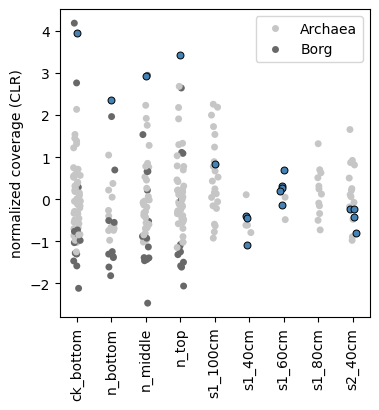

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

domains = ['Bacteria']
domains = ['Archaea', 'Borg']

figure_df = organism_info_df.copy()
figure_df = figure_df.sort_values('metagenome_id')
figure_df['domain'] = [re.search('Archaea|Bacteria|ece_26_1334|Borg|none', taxonomy).group(0) for taxonomy in figure_df.taxonomy]
print('Num. elements with no assigned domain:', (figure_df.domain != 'none').sum())
figure_df = figure_df[figure_df.domain != 'none'].copy()
figure_df.to_csv('sandbox-3_figure-1.csv')

if domains is not None:
    figure_df = figure_df[figure_df.domain.isin(domains + [ece_id])].copy()

sns.stripplot(figure_df[figure_df.taxonomy != ece_id], x='metagenome_id', y='normalized_coverage', hue='domain', palette='Grays')
sns.stripplot(figure_df[figure_df.taxonomy == ece_id], x='metagenome_id', y='normalized_coverage', color='steelblue', linewidth=0.7, edgecolor='black')
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('normalized coverage (CLR)')
plt.show()

In [13]:
ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fasta').seqs[0]
ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()

coordinate_pattern = r'(\d+)..(\d+)'
ece_df['start'] = [int(re.search(coordinate_pattern, coordinate).group(1)) for coordinate in ece_df.coordinate]
ece_df['stop'] = [int(re.search(coordinate_pattern, coordinate).group(2)) for coordinate in ece_df.coordinate]
ece_df['stop_codon'] = [ece_seq[stop - 3:stop] for stop in ece_df.stop]
ece_df['strand'] = np.where(ece_df.coordinate.str.contains('comp'), '-', '+')

ece_df['nt_seq'] = [ece_seq[start, stop] for start, stop in zip(ece_df.start, ece_df.stop)]
ece_df['nt_seq'] = [reverse_complement(row.nt_seq) if (row.strand == '-') else row.nt_seq for row in ece_df.itertuples()] # Reverse complement if on the opposite strand. 

NameError: name 'FASTAFile' is not defined

In [ ]:
# has_cas = False

# fig, ax = plt.subplots(figsize=(4, 4))

# figure_df = blast_df.copy()
# figure_df = figure_df[figure_df.query_domain != 'none'].copy()
# if has_cas:
#     figure_df = figure_df[figure_df.has_cas].copy()

# sns.ecdfplot(figure_df, x='percent_identity', hue='query_domain', palette='Grays')

# legend = ax.get_legend()
# handles = legend.get_lines()
# labels = [label.get_text() for label in legend.get_texts()][:2]
# # labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
# labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
# ax.legend(handles, labels, title='putative host domain')

# ax.set_ylabel('proportion')
# ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter())
# ax.set_xlabel('identity to spacer')

# plt.show()

In [ ]:
blast_df[blast_df.query_domain == 'Archaea'] #.spacer_id.value_counts()
blast_df[blast_df.query_domain == 'Archaea'].query_genome_id.unique()

array([], dtype=object)

In [ ]:
level = 'genus'

mask = (blast_df[f'query_{level}'] != 'none') & (blast_df[f'target_{level}'] != 'none')
df = blast_df[(blast_df.query_domain == 'Archaea') & mask]
print('Num. predicted relationships with taxonomy:', len(df))
df.to_csv('/home/prichter/Downloads/spacerblast_results.csv')
pd.crosstab(df[f'query_{level}'], df[f'target_{level}'])

# Is a member of ANME bacteria, it seems. 

Num. predicted relationships with taxonomy: 2


target_genus,UBA9642
query_genus,
Methanoperedens,2
